In [1]:
!pip install threadpoolctl==3.1.0

In [2]:
import joblib
import os
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from sklearn import datasets, metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


IMG_WIDTH = 250
IMG_HEIGHT = 250

class_names = ['1','2','3','4','5']


data_path = fr'{os.getenv("HOME")}/code/final/kraftwerk/capstone_project/data/classes'
data_path_unknown = fr'{os.getenv("HOME")}/code/final/kraftwerk/capstone_project/data/unclassified'
tflite_model_path = fr'{os.getenv("HOME")}/code/final/kraftwerk/capstone_project/assets/model.tflite'
export_model_path = fr'{os.getenv("HOME")}/code/final/kraftwerk/capstone_project/model'
assets_path = fr'{os.getenv("HOME")}/code/final/kraftwerk/capstone_project/assets/'
export_json_file = os.path.join(assets_path, os.path.splitext(os.path.basename(export_model_path))[0] + ".json")
labelmap_file = fr'{os.getenv("HOME")}/code/final/kraftwerk/capstone_project/assets/labelmap.pbtxt'


In [3]:

def resize_save(src, pklname, width=250, height=250):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    height: int
        target height of the image in pixels.
    """
     
    data = dict()
    data['description'] = 'resized ({0}x{1}) images in rgb for different steps in the process of tea making'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        print('processing directory ' + str(subdir))
        current_path = os.path.join(src, subdir)
        for file in os.listdir(current_path):
            if file[-3:] in {'jpg', 'png'}:
                im = imread(os.path.join(current_path, file))
                im = resize(im, (width, height)) #[:,:,::-1]
                data['label'].append(subdir)
                data['filename'].append(file)
                data['data'].append(im)
 
    joblib.dump(data, pklname)

In [4]:
os.listdir(data_path)

['1', '4', '3', '2', '5']

In [5]:
base_name="tea_steps"
resize_save(src=data_path, pklname=base_name)

processing directory 1
processing directory 4
processing directory 3
processing directory 2
processing directory 5


Load the processed images. 

In [6]:
from collections import Counter
 
data = joblib.load(f'tea_steps_250x250px.pkl')
 
print('Total number of samples: ', len(data['data']))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

Total number of samples:  162
description:  resized (250x250) images in rgb for different steps in the process of tea making
image shape:  (250, 250, 3)
labels: ['1' '2' '3' '4' '5']


Counter({'1': 17, '4': 29, '3': 43, '2': 41, '5': 32})

Look at the 5 different category of images.

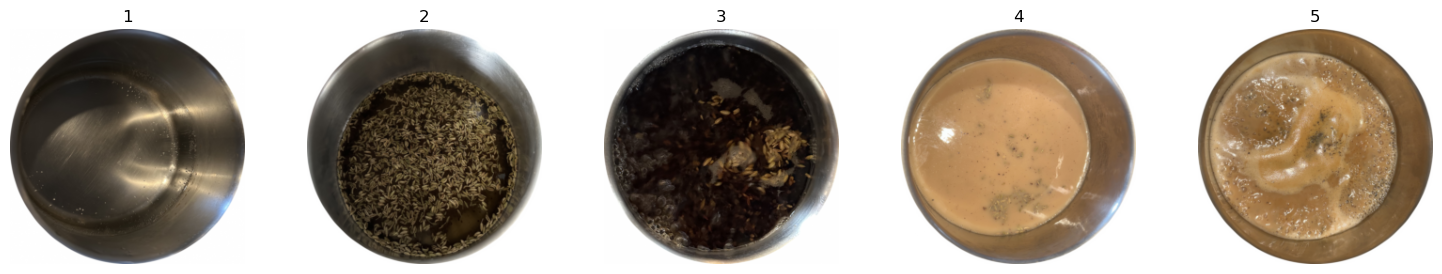

In [7]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [8]:
accuracy_scores_train =[]
accuracy_scores_test =[]
model_descs = []
best_estimators = []
def append_model_accuracy_score(model_desc, accuracy_score_train, accuracy_score_test, best_estimator=''):
  model_descs.append(model_desc)

  accuracy_scores_train.append(accuracy_score_train)
  accuracy_scores_test.append(accuracy_score_test)
  best_estimators.append(best_estimator)

In [9]:
def compute_accuracy(preds, ds):
    train_label = []
    train_score = []
    for pred in preds:
        score = tf.nn.softmax(pred)
        train_label.append(class_names[np.argmax(score)])
    for images, labels in ds:
        for i in range(len(labels)):
            if class_names[labels[i]] == train_label[i]:
                train_score.append(True)
            else:
                train_score.append(False)
    
    return np.sum(train_score)/len(train_score)


def append_dl_model_accuracy_score(model, model_desc,train_ds, test_ds):
    train_pred = model.predict(train_ds)
    train_score = compute_accuracy(train_pred, train_ds)
    test_pred = model.predict(test_ds)
    test_score = compute_accuracy(test_pred, test_ds)
    
    append_model_accuracy_score(model_desc, train_score, test_score)

In [10]:
 
X = np.array(data['data'])
y = np.array(data['label'])
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

GreyScale analysis

In [11]:
X_grey = []
for img2 in data['data']:
    img_gray = rgb2gray(img2)
    X_grey.append(img_gray)

Text(0.5, 1.0, 'Grey Scale')

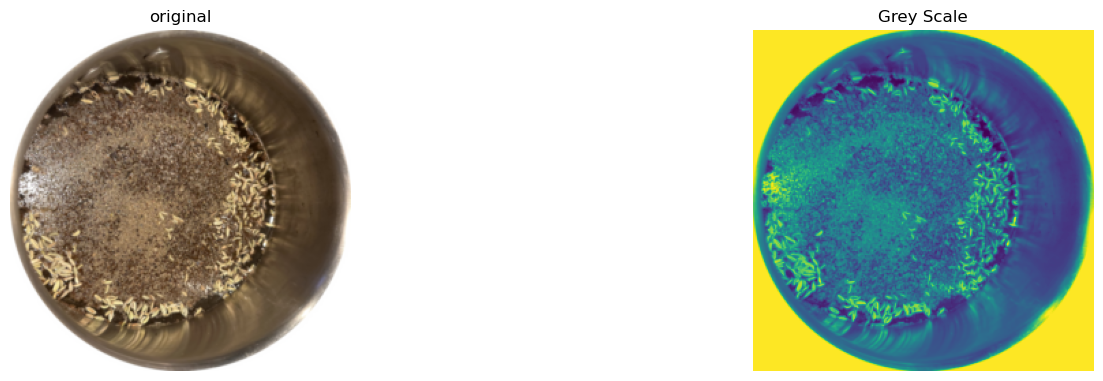

In [12]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,4)
fig.tight_layout()
axes[0].imshow(data['data'][122])
axes[0].axis('off')
axes[0].set_title('original')

axes[1].imshow(X_grey[122])
axes[1].axis('off')
axes[1].set_title('Grey Scale')

In [13]:
X = []
for img2 in data['data']:
    img_gray = np.reshape(X_grey[122],IMG_WIDTH*IMG_HEIGHT)
    X.append(img_gray)
    
X = X
y = np.array(data['label'])
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

In [14]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [15]:
predicted = clf.predict(X_test)

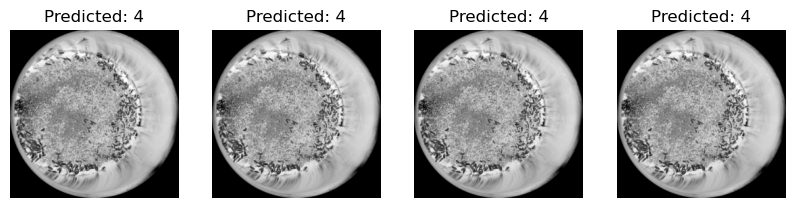

In [16]:
_, axes = plt.subplots(nrows=1, ncols = 4, figsize=(10,3))
for ax, image, predictions in zip(axes, X_test, predicted):
  ax.set_axis_off()
  image= image.reshape(IMG_WIDTH,IMG_HEIGHT)
  ax.imshow(image, cmap = plt.cm.gray_r)
  ax.set_title("Predicted: %s" %predictions)

[False False False False False  True False False False False  True False
 False False  True  True False False False False False  True False False
  True False False False False False False False False]

Percentage correct:  18.181818181818183


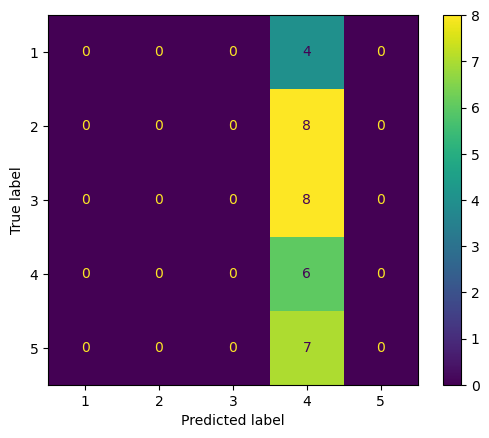

In [17]:
print(np.array(predicted == y_test))
print('')
print('Percentage correct: ', 100*np.sum(predicted == y_test)/len(y_test))
predict_train = clf.predict(X_train)
append_model_accuracy_score('KNeighborsClassifier', np.sum(predict_train == y_train)/len(y_train),np.sum(predicted == y_test)/len(y_test))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)

Perform a grid search for KNeighborsClassifier

In [18]:
params = {'model__n_neighbors':range(5, 50, 5),
          'model__weights':['uniform', 'distance'],
         }
knn_pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('model',KNeighborsClassifier()),
])
knn_grid = GridSearchCV(knn_pipe,  param_grid = params)
knn_grid.fit(X_train, y_train)
knn_grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=45))])

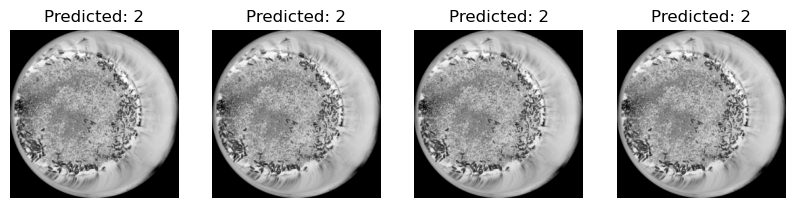

In [19]:
predicted = knn_grid.predict(X_test)
_, axes = plt.subplots(nrows=1, ncols = 4, figsize=(10,3))
for ax, image, predictions in zip(axes, X_test, predicted):
  ax.set_axis_off()
  image= image.reshape(IMG_WIDTH,IMG_HEIGHT)
  ax.imshow(image, cmap = plt.cm.gray_r)
  ax.set_title("Predicted: %s" %predictions)

[False  True False False  True False  True False  True False False False
 False False False False False  True  True False False False False False
 False False  True False False  True False False False]

Percentage correct:  24.242424242424242


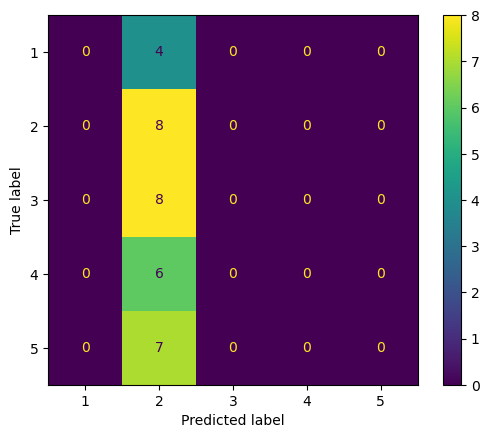

In [20]:
predicted = knn_grid.predict(X_test)
print(np.array(predicted == y_test))
print('')
print('Percentage correct: ', 100*np.sum(predicted == y_test)/len(y_test))
predict_train = knn_grid.predict(X_train)

append_model_accuracy_score('KNeighborsClassifier GridSearch', np.sum(predict_train == y_train)/len(y_train),np.sum(predicted == y_test)/len(y_test),knn_grid.best_estimator_)

metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)

Performing a grid search over a SVC model 

In [21]:
params = {'model__kernel': ['linear','poly','rbf','sigmoid'],
         'model__degree': range(3, 10),
         'model__gamma':['scale', 'auto']}
svc_pipe = Pipeline([('scaler',StandardScaler()),
                      ('model', SVC())])
grid_cv_scv = GridSearchCV(estimator=svc_pipe,param_grid=params,cv=5)
grid_cv_scv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVC())]),
             param_grid={'model__degree': range(3, 10),
                         'model__gamma': ['scale', 'auto'],
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

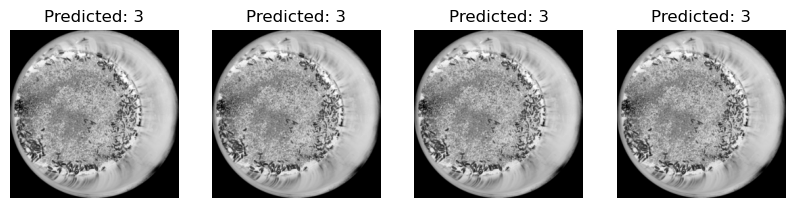

In [22]:
predicted = grid_cv_scv.predict(X_test)
_, axes = plt.subplots(nrows=1, ncols = 4, figsize=(10,3))
for ax, image, predictions in zip(axes, X_test, predicted):
  ax.set_axis_off()
  image= image.reshape(IMG_WIDTH,IMG_HEIGHT)
  ax.imshow(image, cmap = plt.cm.gray_r)
  ax.set_title("Predicted: %s" %predictions)

[False False False  True False False False  True False False False  True
 False  True False False False False False False  True False False False
 False False False  True False False False  True  True]

Percentage correct:  24.242424242424242


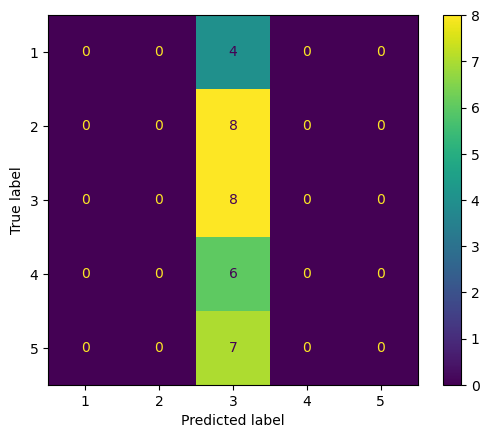

In [23]:
predicted = grid_cv_scv.predict(X_test)
print(np.array(predicted == y_test))
print('')
print('Percentage correct: ', 100*np.sum(predicted == y_test)/len(y_test))
predict_train = grid_cv_scv.predict(X_train)

append_model_accuracy_score('SVC GridSearch(Gray Scale) ', np.sum(predict_train == y_train)/len(y_train),np.sum(predicted == y_test)/len(y_test),grid_cv_scv.best_estimator_)

metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)

We see that the model accuracy continues to stay really low. This is due to the fact that all of the images have the same shape but there is color difference. Hence grey scale analysis is causing the model performance to stay consistently low. 

We need to explore the models that can use the RGB value for creating features. 

We will use the Histogram of Oriented Gradient (HOG) feature extractior https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html

We will still convert to gray scale image and then use skimage.feature.hog to create a feature vector.

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

class RGB2FeatureTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale and extract hog from the resulting image
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(2, 2),#8
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return_arr = []
        for img in X:
            img2 =  skimage.color.rgb2gray(img)
            image_feature = hog(img2,orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
            return_arr.append(image_feature)
        return np.array(return_arr)


In [25]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage 

X = np.array(data['data'])
y = np.array(data['label'])
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

In [26]:
svc_pipe = Pipeline([
    ('xform',RGB2FeatureTransformer(
    pixels_per_cell=(5, 5), 
    cells_per_block=(3,3), 
    orientations=9, 
    block_norm='L2-Hys')),
    ('scalar',StandardScaler()),
    ('clf',SVC(random_state=42, max_iter=1000, tol=1e-3))
])
svc_pipe.fit(X_train,y_train)

Pipeline(steps=[('xform', RGB2FeatureTransformer(pixels_per_cell=(5, 5))),
                ('scalar', StandardScaler()),
                ('clf', SVC(max_iter=1000, random_state=42))])

[False  True  True  True  True  True False  True  True False False  True
  True  True False False False  True False False  True False False False
 False False False  True  True  True False  True  True]

Percentage correct:  51.515151515151516


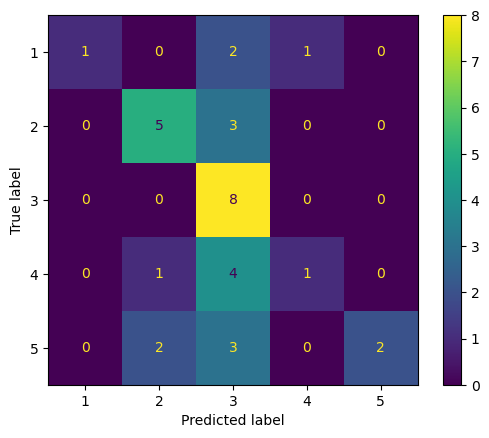

In [27]:
y_pred = svc_pipe.predict(X_test)
print(np.array(y_pred == y_test))
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))
predict_train = svc_pipe.predict(X_train)

append_model_accuracy_score('SVC (RGB) ', np.sum(predict_train == y_train)/len(y_train),np.sum(predicted == y_test)/len(y_test))

metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [28]:
params = {'xform__pixels_per_cell':[(6, 6),(7,7),(8, 8),(9, 9)],
         'xform__cells_per_block':[(2, 2),(3, 3),(4, 4),(5,5)],
          'model__degree': range(3, 10),
         }

svm_pipe = Pipeline([
    ('xform',RGB2FeatureTransformer()),
    ('scalar',StandardScaler()),
    ('model', SVC())
])
svm_grid = GridSearchCV(estimator = svm_pipe, param_grid = params)
svm_grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('xform', RGB2FeatureTransformer()),
                                       ('scalar', StandardScaler()),
                                       ('model', SVC())]),
             param_grid={'model__degree': range(3, 10),
                         'xform__cells_per_block': [(2, 2), (3, 3), (4, 4),
                                                    (5, 5)],
                         'xform__pixels_per_cell': [(6, 6), (7, 7), (8, 8),
                                                    (9, 9)]})

[False  True  True  True  True  True  True  True  True  True False  True
  True  True False False  True  True False False  True  True False  True
  True False False  True  True  True  True  True  True]

Percentage correct:  72.72727272727273


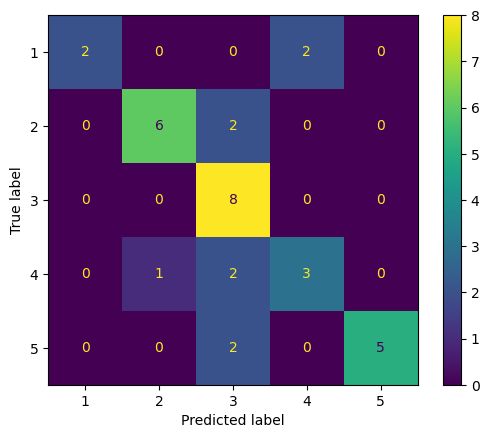

In [29]:
predicted = svm_grid.predict(X_test)
print(np.array(predicted == y_test))
print('')
print('Percentage correct: ', 100*np.sum(predicted == y_test)/len(y_test))
predict_train = svm_grid.predict(X_train)

append_model_accuracy_score('SVC GridSearch(RGB) ', np.sum(predict_train == y_train)/len(y_train),np.sum(predicted == y_test)/len(y_test),svm_grid.best_estimator_)

metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)

Use tensorflow image classification

In [30]:
!pip install tensorflow

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [32]:
import pathlib
data_dir = pathlib.Path(data_path).with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
# define paramters for the loader
batch_size = 200

162


In [33]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 162 files belonging to 5 classes.
Using 130 files for training.


In [34]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 162 files belonging to 5 classes.
Using 32 files for validation.


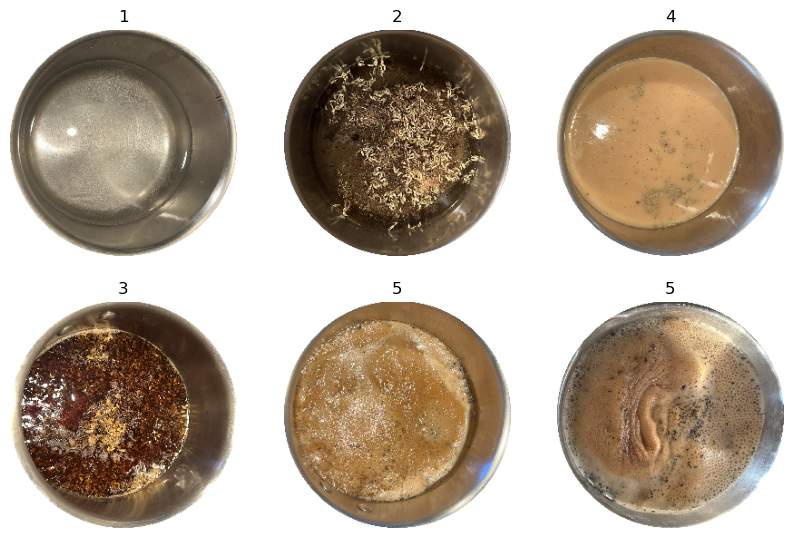

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [36]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
num_classes = len(class_names)

basic_model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [38]:
basic_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 125, 125, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        1

In [40]:
epochs=100
history = basic_model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  verbose=0     
)

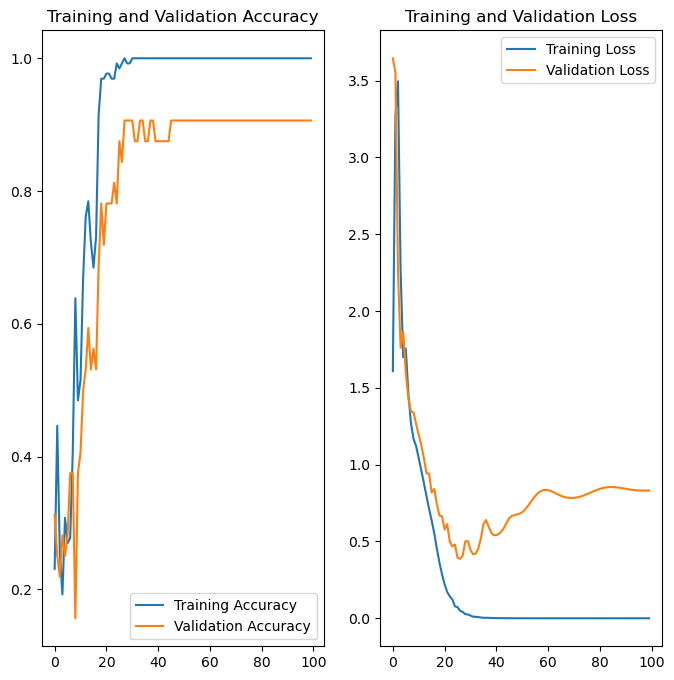

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
append_dl_model_accuracy_score(basic_model,'Sequential',train_ds,test_ds)

1/1 [==============================] - 0s 46ms/step


Data Augmentation

In [43]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(IMG_HEIGHT,
                                  IMG_WIDTH,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

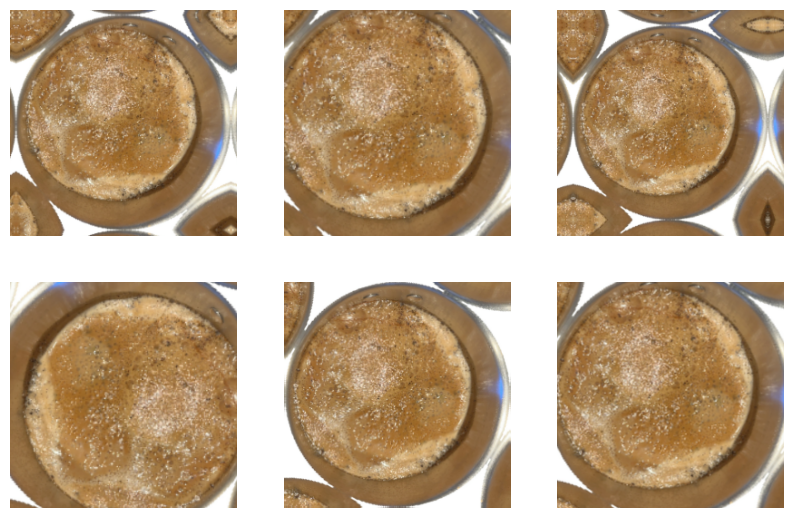

In [44]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(6):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [45]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
  layers.Rescaling(1./255)
])

In [46]:
model_opt = Sequential([
  resize_and_rescale,  
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model_opt.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

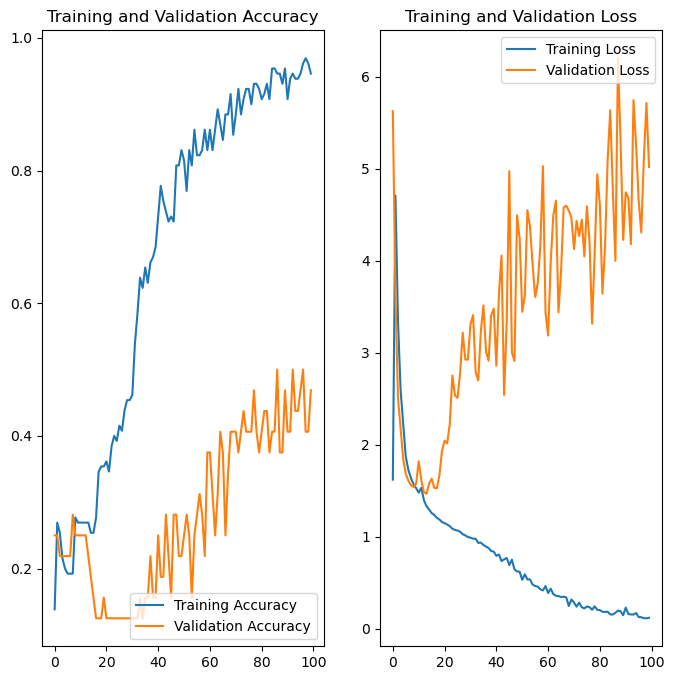

In [47]:
epochs=100
history = model_opt.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  verbose=0,
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
model_opt.summary()
append_dl_model_accuracy_score(model_opt,'Sequential with Rescale, Dropout',train_ds,test_ds)
model_opt.get_metrics_result()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 250, 250, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 250, 250, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 125, 125, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                 

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.019418>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.46875>}

Modify model to have a callback to stop when the accuracy stops to i

In [49]:
model_opt2 = Sequential([
  resize_and_rescale,  
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model_opt2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

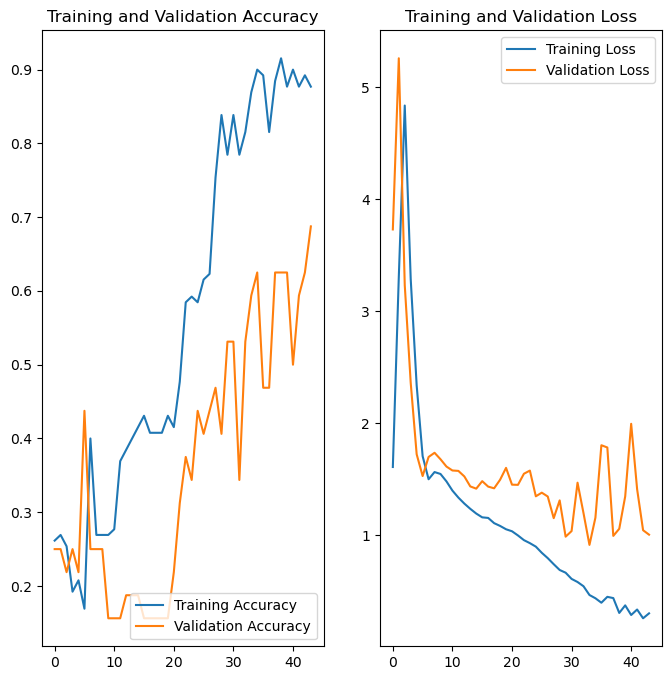

In [50]:
epochs=100
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode="max",restore_best_weights=True,patience=3)
early_stopping = tf.keras.callbacks.EarlyStopping(
                              patience=10,
                              min_delta=1e-10,
                              monitor="val_loss",
                              restore_best_weights=True
                              )
history = model_opt2.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  verbose=0,
  callbacks = [early_stopping]
)

# Visualize the accuracy and the loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
model_opt2.summary()
append_dl_model_accuracy_score(model_opt2,'Sequential with Rescale, Dropout, EarlyStopping',train_ds,test_ds)
model_opt2.get_metrics_result()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 250, 250, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 250, 250, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 125, 125, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                 

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.0039815>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6875>}

In [52]:
unknown_data_path = pathlib.Path(data_path_unknown).with_suffix('')
unknown_ds = tf.keras.utils.image_dataset_from_directory(
  unknown_data_path,
    labels='inferred',
    color_mode='rgb',
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=32)

Found 6 files belonging to 5 classes.


1/1 [==============================] - 0s 10ms/step


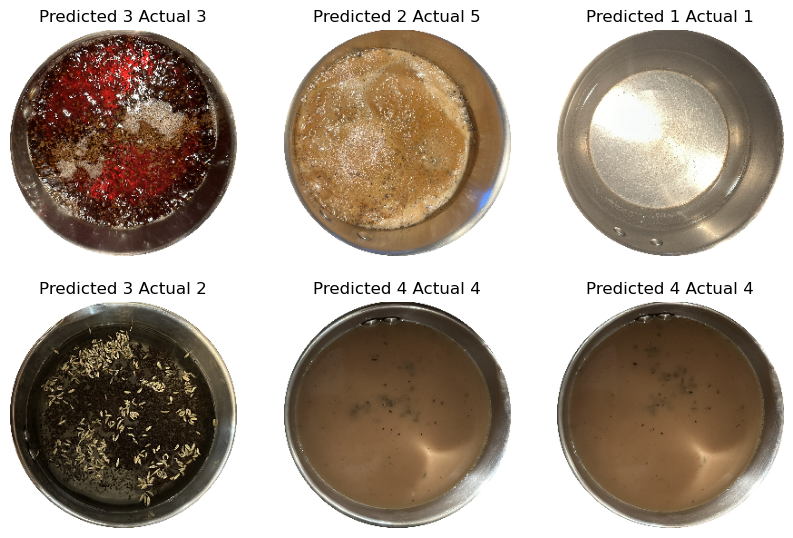

In [53]:
plt.figure(figsize=(10, 10))
for images, labels in unknown_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    img_array = images[i].numpy().astype("uint8")
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model_opt2.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    title = "Predicted "+ class_names[np.argmax(score)] + " Actual "+ class_names[labels[i]]
    plt.title(title)
    plt.axis("off")

In [54]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_opt2)
tflite_model = converter.convert()

# Save the model.
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/cx/mf6gvjzx1tddl1cnr44ngd100000gn/T/tmpof3w1l9x/assets


INFO:tensorflow:Assets written to: /var/folders/cx/mf6gvjzx1tddl1cnr44ngd100000gn/T/tmpof3w1l9x/assets
2023-11-29 22:47:01.413560: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-29 22:47:01.413582: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-29 22:47:01.413834: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/cx/mf6gvjzx1tddl1cnr44ngd100000gn/T/tmpof3w1l9x
2023-11-29 22:47:01.415397: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-29 22:47:01.415402: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/cx/mf6gvjzx1tddl1cnr44ngd100000gn/T/tmpof3w1l9x
2023-11-29 22:47:01.418221: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-11-29 22:47:01.419084: I tensorflow/cc/saved_model/load

In [55]:
print(export_model_path)
save_path = os.path.join(export_model_path, "")
tf.saved_model.save(model_opt2, save_path)

/Users/pulkit/code/final/kraftwerk/capstone_project/model
INFO:tensorflow:Assets written to: /Users/pulkit/code/final/kraftwerk/capstone_project/model/assets


INFO:tensorflow:Assets written to: /Users/pulkit/code/final/kraftwerk/capstone_project/model/assets


https://nbviewer.org/github/quickgrid/CodeLab/blob/master/tensorflow/TFlite_Object_Detection_Custom_Model_Export_With_Metadata_TF1.ipynb

Add Model metadata

In [56]:
!pip install tflite-support

In [57]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

""" ... """
"""Creates the metadata for an image classifier."""

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "Custom Image classifier 250x250 Object Detector"
model_meta.description = ("Detects different steps in the process of Milk Tea making process.")
model_meta.version = "v1"
model_meta.author = "Pulkit Bhanot"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

In [58]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()


In [59]:
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(IMG_WIDTH, IMG_HEIGHT))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)

In [60]:
import os
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the 5 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename(labelmap_file)
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]


In [61]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [62]:
populator = _metadata.MetadataPopulator.with_model_file(tflite_model_path)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files([labelmap_file])
populator.populate()

In [63]:
displayer = _metadata.MetadataDisplayer.with_model_file(tflite_model_path)

json_file = displayer.get_metadata_json()
# Optional: write out the metadata as a json file
with open(export_json_file, "w") as f:
  f.write(json_file)

In [64]:
results = {'model':model_descs,'train score':accuracy_scores_train,'test score':accuracy_scores_test}
results_df = pd.DataFrame(results)
#results_df = results_df.set_index('model')

results_df.sort_values(by='test score', ascending=False)

,model,train score,test score
5,Sequential,1.000000,0.906250
4,SVC GridSearch(RGB),1.000000,0.727273
7,"Sequential with Rescale, Dropout, EarlyStopping",0.853846,0.593750
6,"Sequential with Rescale, Dropout",0.569231,0.468750
1,KNeighborsClassifier GridSearch,0.255814,0.242424
2,SVC GridSearch(Gray Scale),0.271318,0.242424
3,SVC (RGB),1.000000,0.242424
0,KNeighborsClassifier,0.178295,0.181818


In [67]:
pd.set_option('display.max_colwidth', None)
best_models = {'model':model_descs,'best estimator':best_estimators,'test score':accuracy_scores_test}
models_df = pd.DataFrame(best_models)
models_df.sort_values(by='test score', ascending=False)

,model,best estimator,test score
5,Sequential,,0.906250
4,SVC GridSearch(RGB),"(RGB2FeatureTransformer(cells_per_block=(5, 5), pixels_per_cell=(9, 9)), StandardScaler(), SVC())",0.727273
7,"Sequential with Rescale, Dropout, EarlyStopping",,0.593750
6,"Sequential with Rescale, Dropout",,0.468750
1,KNeighborsClassifier GridSearch,"(StandardScaler(), KNeighborsClassifier(n_neighbors=45))",0.242424
2,SVC GridSearch(Gray Scale),"(StandardScaler(), SVC(kernel='linear'))",0.242424
3,SVC (RGB),,0.242424
0,KNeighborsClassifier,,0.181818


In [66]:
#Future work
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator